[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent)

# Agent

## Review

We built a router.

* Our chat model will decide to make a tool call or not based upon the user input
* We use a conditional edge to route to a node that will call our tool or simply end

![Screenshot 2024-08-21 at 12.44.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0ba0bd34b541c448cc_agent1.png)

## Goals

Now, we can extend this into a generic agent architecture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.
 
But, what if we simply pass that `ToolMessage` *back to the model*?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind [ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This [general purpose architecture](https://blog.langchain.dev/planning-for-agents/) can be applied to many types of tools. 

![Screenshot 2024-08-21 at 12.45.43 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac0b4a2c1e5e02f3e78b_agent2.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langchain_ollama

In [6]:
from langchain_ollama import ChatOllama
import random
from typing import Union

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

def return_random_number(x: Union[int, str]) -> float:
    """Multiply x by a random number
       between 0 and 1.

    Args:
        x: first int
    """
    return int(x) * random.random()

tools = [add, multiply, divide]
llm = ChatOllama(
    model="llama3.1:8b-instruct-q8_0",
    temperature=0,
    # other params...
)

llm_steps_checker = ChatOllama(
    model="llama3.1:8b-instruct-q8_0",
    temperature=0,
    # other params...
)

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!

#llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)
llm_with_tools = llm.bind_tools(tools)

Let's create our LLM and prompt it with the overall desired agent behavior.

In [7]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# System message
sys_msg_assistant = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                        " The tools need to be used sequentially. If you don't have the previous result, calculate"
                        " that result first. You will be called back with the previous value, so don't worry about"
                        " doing multiple calculations at once, which is completely wrong!")

# Node
def assistant(state: MessagesState):
   print("=> Entering assistant node") # Debugging print
   print("=> Assistant State:", state["messages"], state.get("tasks")) # Debugging print
   result = llm_with_tools.invoke([sys_msg_assistant] + state["messages"], stream=False)
   print("=> Assistant Result:", result) # Debugging print
   return {"messages": [result]}

In [8]:
sys_msg_steps_manager = SystemMessage(content="You are a helpful assistant that splits the tasks in steps. "
                                              "But do not resolve the tasks.")

def steps_manager(state: MessagesState):
   print("=> Entering steps_manager node") # Debugging print
   print("=> Steps Manager State:", state["messages"]) # Debugging print
   aimessage = llm_steps_checker.invoke([sys_msg_steps_manager] + state["messages"], stream=False)
   print("=> Steps Manager Result:", aimessage) # Debugging print
   humman_message = HumanMessage(content="Process each task individually")
   return MessagesState({"messages": state["messages"] + [aimessage] + [humman_message]})

"""
https://medium.com/@gitmaxd/understanding-state-in-langgraph-a-comprehensive-guide-191462220997
def add_message(state: ComplexState, message: str, is_human: bool = True) -> ComplexState:
    new_message = HumanMessage(content=message) if is_human else AIMessage(content=message)
    return ComplexState(
        count=state["count"],
        messages=state["messages"] + [new_message]
    )
"""
from pydantic import BaseModel, Field
from typing import List  # Import List from typing

class Task(BaseModel):
    task_id: str = Field(description="Task id")
    task_message: str = Field(description="The task")


llm_steps_checker.with_structured_output(List[Task], method="json_mode")

RunnableBinding(bound=ChatOllama(model='llama3.1:8b-instruct-q8_0', temperature=0.0), kwargs={'format': 'json', 'structured_output_format': {'kwargs': {'method': 'json_mode'}, 'schema': typing.List[__main__.Task]}}, config={}, config_factories=[])
| JsonOutputParser()

As before, we use `MessagesState` and define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

In [9]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5.")]
llm_steps_checker.invoke("Add 3 and 4. Multiply the output by 2. Divide the output by 5.")

AIMessage(content='To solve this problem, we need to follow the order of operations:\n\n1. Add 3 and 4:\n   3 + 4 = 7\n\n2. Multiply the output (7) by 2:\n   7 × 2 = 14\n\n3. Divide the output (14) by 5:\n   14 ÷ 5 = 2.8', additional_kwargs={}, response_metadata={'model': 'llama3.1:8b-instruct-q8_0', 'created_at': '2025-02-19T09:09:13.156589053Z', 'done': True, 'done_reason': 'stop', 'total_duration': 29998988592, 'load_duration': 6221902267, 'prompt_eval_count': 31, 'prompt_eval_duration': 1472000000, 'eval_count': 80, 'eval_duration': 22301000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-214f7815-c5be-477a-a4aa-edbabdd22c59-0', usage_metadata={'input_tokens': 31, 'output_tokens': 80, 'total_tokens': 111})

In [10]:
from langchain_core.messages import AIMessage
from langchain.output_parsers import PydanticOutputParser

# https://python.langchain.com/v0.1/docs/modules/model_io/output_parsers/types/pydantic/
class Task(BaseModel):
    id: str = Field(description="The task id")
    message: str = Field(description="The task message")


message = AIMessage(content='{"id": "1", "message": "Add 3 and 4."}')
parser = PydanticOutputParser(pydantic_object=Task)
parser.invoke(message)

Task(id='1', message='Add 3 and 4.')

In [29]:
from pydantic import BaseModel, Field

class Task(BaseModel):
    task_id: str = Field(description="The task id")
    description: str = Field(description="The task message")


class Tasks(BaseModel):
    queue: List[Task]
    status: str = Field(description="Field to set the status 'SUCCESS' or 'FAILURE'")
                        
"""
class Tasks(BaseModel):
    tasks: List[str]
"""  
test_structured_llm = ChatOllama(
    model="llama3.1:8b-instruct-q8_0",
    temperature=0,
    # other params...
)
PROMPT = """
You are an AI designed to break down a given problem into a structured list of tasks. Each task should be clearly defined and sequentially dependent on the previous one, but you should not solve the problem.

Return a JSON array where each element is an object representing a single step in the process. If you cannot infer any tasks, set the "status" field to 'FAILURE'.

Example instruction:
    "Take the mug out, add the tea bag and pour the boiling water."
Return:
{
    "queue": [
      {"task_id": "1", "description": "Take the mug out."},
      {"task_id": "2", "description": "Add the tea bag."},
      {"task_id": "3", "description": "Pour the boiling water."}
    ],
    "status": "SUCCESS"
}

Example instruction:
    "The sky is blue and I am very happy".
Return:
{
    "tasks": [],
    "status": "FAILURE"
}
"""
structured_llm = test_structured_llm.with_structured_output(Tasks, method="json_mode")
SYSTEM_MESSAGE = SystemMessage(content=PROMPT)
human_message = HumanMessage(content="Add 3 and 4, multiply the output by 2 and divide the output by 5.")
#structured_llm.invoke("Split the following sentence in tasks: 'Add 3 and 4. Multiply the output by 2. Divide the output by 5.'")
structured_llm.invoke([SYSTEM_MESSAGE] + [human_message])

Tasks(queue=[Task(task_id='1', description='Add 3.'), Task(task_id='2', description='Add 4.'), Task(task_id='3', description='Multiply the output by 2.'), Task(task_id='4', description='Divide the output by 5.')], status='SUCCESS')

In [58]:
message = AIMessage(content='{"queue":[{"task_id": "1", "description": "Add 3 and 4."},{"task_id": "2", "description": "Multiply by 2."}],"status":"SUCCESS"}')
parser = PydanticOutputParser(pydantic_object=Tasks)
parsed_tasks = parser.invoke(message)
print(parsed_tasks)

from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage, ToolMessage
from langgraph.graph.message import add_messages
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

class TasksMessageState(TypedDict):
    tasks: Tasks
    messages: Annotated[list[AnyMessage], add_messages]
    tools_called: int = 0
    
def steps_manager(state: TasksMessageState):
   printmd("**=> Entering steps_manager node**") # Debugging print
   printmd("**=> Steps Manager State**") # Debugging print
   print(id(state))
   for m in state['messages']:
       m.pretty_print()
   aimessage = structured_llm.invoke([SYSTEM_MESSAGE] + state["messages"], stream=False)
   #aimessage = parsed_tasks
   printmd("**=> Steps Manager Result:**")
   print(aimessage) # Debugging print
   #humman_message = HumanMessage(content="Process each task individually")
   return TasksMessageState(messages=state["messages"], tasks=aimessage, tools_called=0)

def assistant(state: TasksMessageState):
   printmd("**=> Entering assistant node**") # Debugging print
   printmd("**=> Assistant State:**") # Debugging print
   print(state["tasks"])
   print(state["tools_called"])
   print(id(state))
   print(id(state["tasks"]))
   for m in state['messages']:
       m.pretty_print()
       print(type(m))
   tasks = state["tasks"]
   if tasks.status != "SUCCESS":
       return {"messages": AIMessage(content="Unfortunately I am unable to process your request.")}
   elif tasks.queue:
       task = tasks.queue.pop(0)
       # If previous message is a ToolMessage (recurrent call), then
       # get the value of the tool and use it
       if isinstance(state['messages'][-1], ToolMessage):
           last_value = str(state['messages'][-1].content)
           human_message = HumanMessage(content=f"You are evaluating a task that is using a previous result with value '{last_value}': '{task.description}'")
       else:
           human_message = HumanMessage(content=f"Evaluate task: '{task.description}'")
       human_message.pretty_print()
       result = llm_with_tools.invoke([human_message], stream=False)
       printmd("**=> Tool Result:**") # Debugging print
       print(type(result))
       print(result)
       #return {"messages": state['messages'] + [human_message] + [result]}
       # It's not necessary to pass task. Apparently, if you don't pass the field it will show up when
       # assistant gets called back. Still I am not sure how this works.
       return {"messages": [result], "tasks": tasks, "tools_called": state["tools_called"] + 1}  
   else:
       if isinstance(state['messages'][-1], ToolMessage):
           last_value = str(state['messages'][-1].content)
           return {"messages": AIMessage(content=f"The result is {last_value}")}
       else:
           # If the queue is empty but the last message wasn't
           # a ToolMessage, then "steps_manager" returned an empty queue
           # with status "SUCCESS".
           return {"messages": "Nothing to process"}

queue=[Task(task_id='1', description='Add 3 and 4.'), Task(task_id='2', description='Multiply by 2.')] status='SUCCESS'


In [54]:
parsed_tasks

Tasks(queue=[Task(task_id='1', description='Add 3 and 4.'), Task(task_id='2', description='Multiply by 2.')], status='SUCCESS')

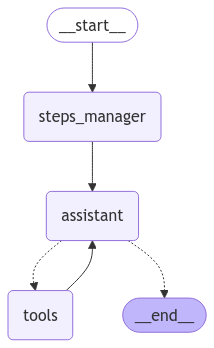

In [59]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(TasksMessageState)

# Define nodes: these do the work
builder.add_node("steps_manager", steps_manager)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "steps_manager")
builder.add_edge("steps_manager", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [60]:
#messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2.")]
messages = [HumanMessage(content="Multiply 3 and 4. Multiply the output by 2. Divide the output by 5.")]
#messages = [HumanMessage(content="Champaign!")]
#messages = [HumanMessage(content="Add 3 and 4. Execute previous result by function return_random_number. Divide the last output by 5.")]
messages = react_graph.invoke({"messages": messages})

**=> Entering steps_manager node**

**=> Steps Manager State**

140056238077184
================================ Human Message =================================

Multiply 3 and 4. Multiply the output by 2. Divide the output by 5.


**=> Steps Manager Result:**

queue=[Task(task_id='1', description='Multiply 3 and 4.'), Task(task_id='2', description='Multiply the output by 2.'), Task(task_id='3', description='Divide the output by 5.')] status='SUCCESS'


**=> Entering assistant node**

**=> Assistant State:**

queue=[Task(task_id='1', description='Multiply 3 and 4.'), Task(task_id='2', description='Multiply the output by 2.'), Task(task_id='3', description='Divide the output by 5.')] status='SUCCESS'
0
140056209221248
140056210136400
================================ Human Message =================================

Multiply 3 and 4. Multiply the output by 2. Divide the output by 5.
<class 'langchain_core.messages.human.HumanMessage'>
================================ Human Message =================================

Evaluate task: 'Multiply 3 and 4.'


**=> Tool Result:**

<class 'langchain_core.messages.ai.AIMessage'>
content='' additional_kwargs={} response_metadata={'model': 'llama3.1:8b-instruct-q8_0', 'created_at': '2025-02-19T09:44:33.003245913Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6782898089, 'load_duration': 13435131, 'prompt_eval_count': 290, 'prompt_eval_duration': 1332000000, 'eval_count': 22, 'eval_duration': 5436000000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='multiply', arguments={'a': 3, 'b': 4}))])} id='run-ff69358a-fbe9-47d0-8749-ecf28bf88d0b-0' tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 4}, 'id': '815fb200-7a28-4a50-aac0-56b135287b14', 'type': 'tool_call'}] usage_metadata={'input_tokens': 290, 'output_tokens': 22, 'total_tokens': 312}


**=> Entering assistant node**

**=> Assistant State:**

queue=[Task(task_id='2', description='Multiply the output by 2.'), Task(task_id='3', description='Divide the output by 5.')] status='SUCCESS'
1
140056210087616
140056210136400
================================ Human Message =================================

Multiply 3 and 4. Multiply the output by 2. Divide the output by 5.
<class 'langchain_core.messages.human.HumanMessage'>
================================== Ai Message ==================================
Tool Calls:
  multiply (815fb200-7a28-4a50-aac0-56b135287b14)
 Call ID: 815fb200-7a28-4a50-aac0-56b135287b14
  Args:
    a: 3
    b: 4
<class 'langchain_core.messages.ai.AIMessage'>
================================= Tool Message =================================
Name: multiply

12
<class 'langchain_core.messages.tool.ToolMessage'>
================================ Human Message =================================

You are evaluating a task that is using a previous result with value '12': 'Multiply the output by 2.'


**=> Tool Result:**

<class 'langchain_core.messages.ai.AIMessage'>
content='' additional_kwargs={} response_metadata={'model': 'llama3.1:8b-instruct-q8_0', 'created_at': '2025-02-19T09:44:40.89350908Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7883777746, 'load_duration': 11442017, 'prompt_eval_count': 303, 'prompt_eval_duration': 1526000000, 'eval_count': 22, 'eval_duration': 6345000000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='multiply', arguments={'a': '12', 'b': '2'}))])} id='run-ad0bb71d-39f8-45e7-8946-b5ba23bc11c0-0' tool_calls=[{'name': 'multiply', 'args': {'a': 12, 'b': 2}, 'id': 'a111b165-1a97-4159-bb53-a35a0adeeb64', 'type': 'tool_call'}] usage_metadata={'input_tokens': 303, 'output_tokens': 22, 'total_tokens': 325}


**=> Entering assistant node**

**=> Assistant State:**

queue=[Task(task_id='3', description='Divide the output by 5.')] status='SUCCESS'
2
140056209505344
140056210136400
================================ Human Message =================================

Multiply 3 and 4. Multiply the output by 2. Divide the output by 5.
<class 'langchain_core.messages.human.HumanMessage'>
================================== Ai Message ==================================
Tool Calls:
  multiply (815fb200-7a28-4a50-aac0-56b135287b14)
 Call ID: 815fb200-7a28-4a50-aac0-56b135287b14
  Args:
    a: 3
    b: 4
<class 'langchain_core.messages.ai.AIMessage'>
================================= Tool Message =================================
Name: multiply

12
<class 'langchain_core.messages.tool.ToolMessage'>
================================== Ai Message ==================================
Tool Calls:
  multiply (a111b165-1a97-4159-bb53-a35a0adeeb64)
 Call ID: a111b165-1a97-4159-bb53-a35a0adeeb64
  Args:
    a: 12
    b: 2
<class 'langchain_core.messages.ai.AIMessage'>
===

**=> Tool Result:**

<class 'langchain_core.messages.ai.AIMessage'>
content='' additional_kwargs={} response_metadata={'model': 'llama3.1:8b-instruct-q8_0', 'created_at': '2025-02-19T09:44:47.771220685Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6870977006, 'load_duration': 11518731, 'prompt_eval_count': 304, 'prompt_eval_duration': 867000000, 'eval_count': 22, 'eval_duration': 5991000000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='divide', arguments={'a': '24', 'b': '5'}))])} id='run-85cf688f-465f-4703-a992-84f3eedd7d3f-0' tool_calls=[{'name': 'divide', 'args': {'a': 24, 'b': 5}, 'id': '3162d58d-8782-4e2f-87de-3a6713469c91', 'type': 'tool_call'}] usage_metadata={'input_tokens': 304, 'output_tokens': 22, 'total_tokens': 326}


**=> Entering assistant node**

**=> Assistant State:**

queue=[] status='SUCCESS'
3
140056210926208
140056210136400
================================ Human Message =================================

Multiply 3 and 4. Multiply the output by 2. Divide the output by 5.
<class 'langchain_core.messages.human.HumanMessage'>
================================== Ai Message ==================================
Tool Calls:
  multiply (815fb200-7a28-4a50-aac0-56b135287b14)
 Call ID: 815fb200-7a28-4a50-aac0-56b135287b14
  Args:
    a: 3
    b: 4
<class 'langchain_core.messages.ai.AIMessage'>
================================= Tool Message =================================
Name: multiply

12
<class 'langchain_core.messages.tool.ToolMessage'>
================================== Ai Message ==================================
Tool Calls:
  multiply (a111b165-1a97-4159-bb53-a35a0adeeb64)
 Call ID: a111b165-1a97-4159-bb53-a35a0adeeb64
  Args:
    a: 12
    b: 2
<class 'langchain_core.messages.ai.AIMessage'>
================================= Tool Message ============

In [63]:
print(messages["tasks"])
print(messages["tools_called"])
for m in messages['messages']:
    m.pretty_print()

queue=[] status='SUCCESS'
3
================================ Human Message =================================

Multiply 3 and 4. Multiply the output by 2. Divide the output by 5.
================================== Ai Message ==================================
Tool Calls:
  multiply (815fb200-7a28-4a50-aac0-56b135287b14)
 Call ID: 815fb200-7a28-4a50-aac0-56b135287b14
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================
Tool Calls:
  multiply (a111b165-1a97-4159-bb53-a35a0adeeb64)
 Call ID: a111b165-1a97-4159-bb53-a35a0adeeb64
  Args:
    a: 12
    b: 2
================================= Tool Message =================================
Name: multiply

24
================================== Ai Message ==================================
Tool Calls:
  divide (3162d58d-8782-4e2f-87de-3a6713469c91)
 Call ID: 3162d58d-8782-4e2f-87de-3a6713469c91
 

In [39]:
messages = react_graph.invoke({"messages": "You did it wrong, calculated all the tool values without knowin the results"})

In [40]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

You did it wrong, calculated all the tool values without knowin the results
================================== Ai Message ==================================
Tool Calls:
  multiply (653ae37c-e30a-46fa-81e6-a0751591749d)
 Call ID: 653ae37c-e30a-46fa-81e6-a0751591749d
  Args:
    a: 3
    b: 4
  add (b1bccdf7-f6f2-4af3-bd77-b382e047fec1)
 Call ID: b1bccdf7-f6f2-4af3-bd77-b382e047fec1
  Args:
    a: 2
    b: 12
  multiply (17ddc6b1-95bb-42a6-9a44-0605bf637808)
 Call ID: 17ddc6b1-95bb-42a6-9a44-0605bf637808
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: multiply

12
================================= Tool Message =================================
Name: add

14
================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================
Tool Cal

## LangSmith

We can look at traces in LangSmith.